In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import tools

In [5]:
plt.style.use("coolbeans")

In [6]:
DB_PATH = "./data/stationdb.sqlite"
ERAI_PATH = "./data/erai.npz"
OISST_PATH = "./data/oisst.npz"
SHORTCALYEAR_LOW = 1982
SHORTCALYEAR_HIGH = 2012
WESTOFLON = -104
EASTOFLON = -125

In [7]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, SHORTCALYEAR_LOW, SHORTCALYEAR_HIGH, WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, wy, avg(mean) FROM StationMonthly WHERE wy <= 2012 AND wy >= 1983 AND stationid IN ({seq}) GROUP BY stationid, wy ORDER BY stationid, wy ASC".format(seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["wy", "stationid"])
conn.close()

In [8]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, latgage, longage FROM StationInfo WHERE stationid IN ({seq}) ORDER BY stationid ASC".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

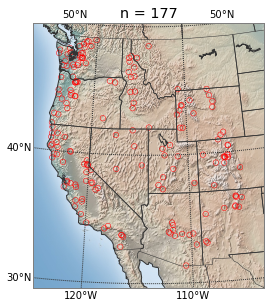

In [9]:
# Plot simple sample map.
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())


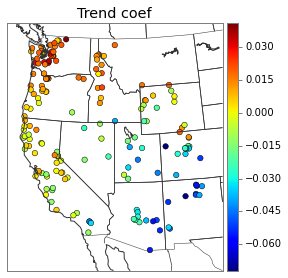

In [10]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "stationid")["avg(mean)"].transform(tools.spigamma)

trend_coefs = parsed.groupby(level = "stationid").apply(tools.trender)
# Detrending. Let's see what happens.
# parsed = parsed.groupby(level = "stationid").transform(signal.detrend)
parsed = parsed.unstack()

# Map trend coefs.
out = tools.plot_trendmap(trend_coefs, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

In [11]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.

solver = eofs.Eof(parsed.as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = 6)
pc = solver.pcs(npcs = 6, pcscaling = 1)
frac_var = solver.varianceFraction(6)

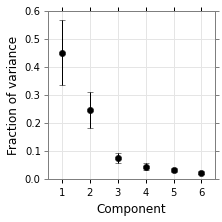

In [12]:
# Basic North Test plot

out = tools.plot_northtest(solver, nmodes = 6)

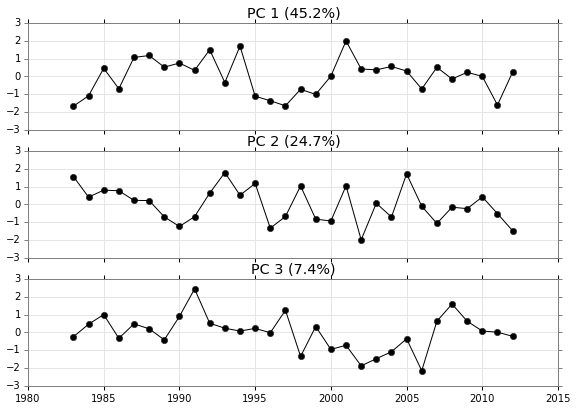

In [13]:
# Plot 6 leading PCs.

out = tools.plot_pc(solver, yr = np.arange(SHORTCALYEAR_LOW + 1, SHORTCALYEAR_HIGH + 1), nmodes = 3)

/usr/local/lib/python3.4/dist-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


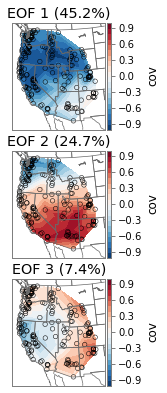

In [14]:
# Plot 6 leading EOFs.

out = tools.plot_eof(solver, lat = latlon["latgage"].as_matrix(), lon = latlon["longage"].as_matrix(), nmodes = 3)

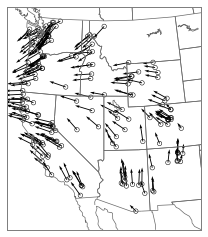

In [15]:
rcoef1 = parsed.stack().groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.stack().groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])
# print(rcoef1)
# print(rcoef2)
plt.figure(figsize = (5, 4))
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
x, y = m(latlon["longage"].as_matrix(), latlon["latgage"].as_matrix())
m.drawcoastlines(linewidth = 0.7, color = "#696969")
m.drawstates(linewidth = 0.7, color = "#696969")
m.drawcountries(linewidth = 0.7, color = "#696969")
m.quiver(x, y, rcoef1, rcoef2, scale = 10)
m.scatter(x, y, facecolors = "none", edgecolor = "k")
plt.show()

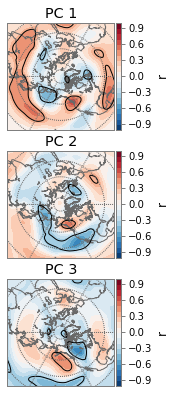

In [16]:
# Plot NDJ 500 mb point correlations.

erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= SHORTCALYEAR_LOW + 1) & (erai["time"] <= SHORTCALYEAR_HIGH)
hgts = erai["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts, lat = erai["lat"], lon = erai["lon"], nmodes = 3)

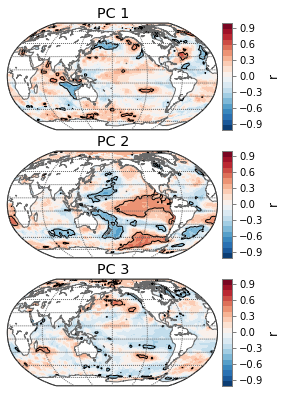

In [17]:
# Correlate PCs with OI SST data (NDJ mean) detrended anomalies.

oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= SHORTCALYEAR_LOW + 1) & (oisst["time"] <= SHORTCALYEAR_HIGH)
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, lat = oisst["lat"], lon = oisst["lon"], nmodes = 3, msk = oisst["landmask"], world_map = True)

In [18]:
# Composite map of NDJ mean 500 mb height anomalies.
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= SHORTCALYEAR_LOW + 1) & (erai["time"] <= SHORTCALYEAR_HIGH)
hgts = erai["data"][0, 1, msk_time]

import imp
imp.reload(tools)

comp_pc1, comp_pc1_yr = tools.field_composite(pc[:, 0], np.arange(SHORTCALYEAR_LOW + 1, SHORTCALYEAR_HIGH + 1), hgts)
print(comp_pc1["low"].shape)

# # First dim is PC, second is 0 -> low, 1 -> high:
# composit_anoms = np.zeros((2, 2, hgts.shape[1], hgts.shape[2]))
# for i in range(2):
#     quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
#     composit_anoms[i, 0] = np.mean(hgts[(quarts == "low")], 0) - np.mean(hgts, 0)
#     composit_anoms[i, 1] = np.mean(hgts[(quarts == "high")], 0) - np.mean(hgts, 0)

# wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
# divs = np.linspace(-wings, wings, 21)
# divs2 = np.linspace(-wings, wings, 11)
# fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
# for i in range(2):
#     m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
#     x, y = m(erai["lon"], erai["lat"])
#     m.drawcoastlines(color = "#696969")
#     m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
#     m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
# #     m.contour(x, y, composit_anoms[0, i], divs2, colors = "k")
#     pcol = m.contourf(x, y, composit_anoms[0, i], divs, cmap = plt.cm.RdBu_r)
#     cb = m.colorbar(pcol)
#     cb.set_label("Anomaly mean (m)")
#     axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " ERA-I 500mb NDJ composit")
# plt.show()
    
# fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
# for i in range(2):
#     m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
#     x, y = m(erai["lon"], erai["lat"])
#     m.drawcoastlines(color = "#696969")
#     m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
#     m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
# #     m.contour(x, y, composit_anoms[1, i], divs2, colors = "k")
#     pcol = m.contourf(x, y, composit_anoms[1, i], divs, cmap = plt.cm.RdBu_r)
#     cb = m.colorbar(pcol)
#     cb.set_label("Anomaly mean (m)")    
#     axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " ERA-I 500mb NDJ composit")
# plt.show()

# quarts = pd.qcut(pc[:, 0], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
# print("PC1 low+high:")
# print(yr[quarts == "low"])
# print(yr[quarts == "high"])
# quarts = pd.qcut(pc[:, 1], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
# print("PC2 low+high:")
# print(yr[quarts == "low"])
# print(yr[quarts == "high"])

(15, 256, 512)


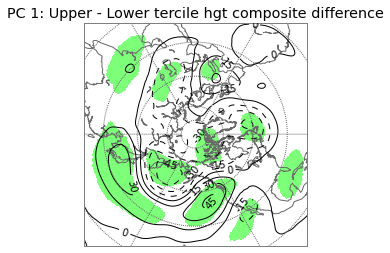

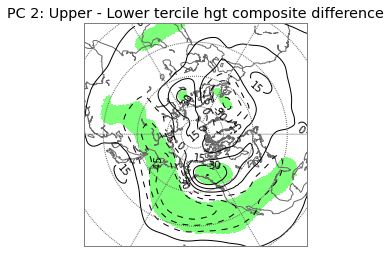

In [19]:
# Welch's t-test comparing upper and lower quartiles.
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    t, p = stats.ttest_ind(hgts[(quarts == "high")], hgts[(quarts == "low")], equal_var = False)
    d = np.mean(hgts[(quarts == "high")], 0) - np.mean(hgts[(quarts == "low")], 0)
    plt.figure(figsize = (5, 4))
    m = Basemap(projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    c = np.ma.masked_array(p, ~(p <= 0.1))
    x, y = m(erai["lon"], erai["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    ct = m.contour(x, y, d, colors = "k")
    plt.clabel(ct, fontsize = 10, inline = 1, fmt = "%1.0f")
    m.contourf(x, y, c, 0)
    plt.title("PC " + str(i + 1) + ": Upper - Lower tercile hgt composite difference")
    plt.show()

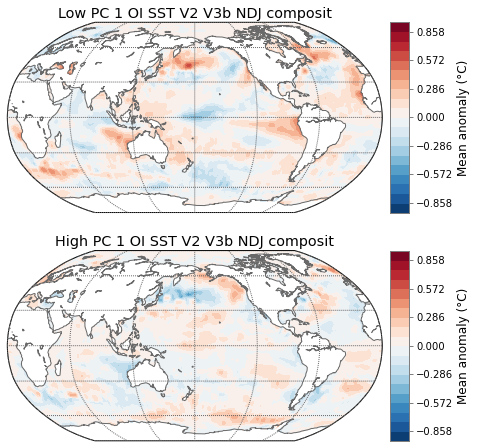

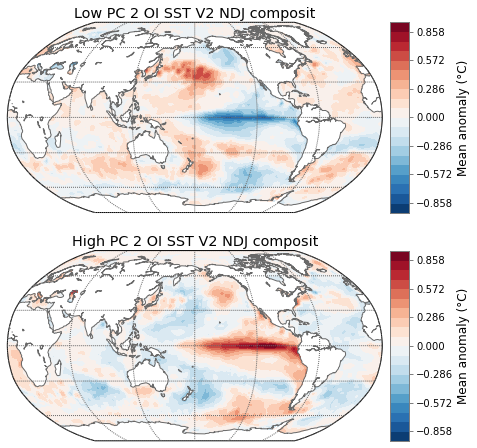

PC1 low+high:


NameError: name 'yr' is not defined

In [20]:
# Composite map of NDJ detrended sea surface temperature anomalies.
oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= SHORTCALYEAR_LOW + 1) & (oisst["time"] <= SHORTCALYEAR_HIGH)
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")

# First dim is PC, second is 0 -> low, 1 -> high:
composit_anoms = np.zeros((2, 2, sst.shape[1], sst.shape[2]))
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    composit_anoms[i, 0] = np.mean(sst[(quarts == "low")], 0) - np.mean(sst, 0)
    composit_anoms[i, 1] = np.mean(sst[(quarts == "high")], 0) - np.mean(sst, 0)

wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
divs = np.linspace(-wings, wings, 21)
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[0, i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("Mean anomaly (°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " OI SST V2 V3b NDJ composit")
plt.show()

fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[1, i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("Mean anomaly (°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " OI SST V2 NDJ composit")
plt.show()

quarts = pd.qcut(pc[:, 0], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
print("PC1 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])
quarts = pd.qcut(pc[:, 1], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
print("PC2 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])

In [ ]:
# Welch's t-test comparing upper and lower quartiles.
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    t, p = stats.ttest_ind(sst[(quarts == "high")], sst[(quarts == "low")], equal_var = False)
    d = np.mean(sst[(quarts == "high")], 0) - np.mean(sst[(quarts == "low")], 0)
    d = np.ma.masked_array(d, oisst["landmask"])
    p = np.ma.masked_array(p, oisst["landmask"])
    plt.figure(figsize = (8, 4))
    m = Basemap(projection = "robin", lon_0 = 180, resolution = "c")
    c = np.ma.masked_array(p, ~(p <= 0.1))
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    ct = m.contour(x, y, d, colors = "k")
    plt.clabel(ct, fontsize=8, inline=1, fmt = "%1.1f")
    m.contourf(x, y, c, 0)
    plt.title("PC " + str(i + 1) + ": Upper - Lower tercile SST composite difference")
    plt.show()